In [15]:
import numpy as np
from pynn_brainscales import brainscales2 as pynn
from pynn_brainscales.brainscales2.morphology import create_mc_neuron, \
    Compartment, SharedLineConnection
from pynn_brainscales.brainscales2.standardmodels.cells import SpikeSourceArray
from pynn_brainscales.brainscales2.standardmodels.synapses import StaticSynapse
import quantities
from matplotlib import pyplot as plt

In [16]:
from _static.common.helpers import setup_hardware_client
setup_hardware_client()

from _static.common.helpers import get_nightly_calibration
calib = get_nightly_calibration()

refractory_clock_scale = 7

for backend in calib.neuron_block.backends:
    backend.clock_scale_fast = refractory_clock_scale
    
period_refractory_clock = 1. / (250e6 / 2**(refractory_clock_scale + 1))
print(period_refractory_clock)

# setup PyNN and inject calibration data
pynn.setup(initial_config=calib)

1.024e-06


In [17]:
def create_excitatory_neurons(num: int):
    all_neurons = pynn.Population(num * 2, pynn.cells.HXNeuron())

    dendrites = pynn.PopulationView(all_neurons, list(range(0, num * 2, 2)))
    somas = pynn.PopulationView(all_neurons, list(range(1, num * 2, 2)))
                                                                                                                                                             
    dendrites.set(
        multicompartment_enable_conductance=True,
        multicompartment_i_bias_nmda=30,
        multicompartment_connect_soma_right=True,
        reset_v_reset=800,
        refractory_period_reset_holdoff=0,
        refractory_period_refractory_time=75,
    )

    somas.set(
        multicompartment_connect_soma=True,
        refractory_period_refractory_time=10,
    )
    somas.record(["spikes"])
    
    return dendrites, somas

In [18]:
def create_inhibitory_neurons(num: int):
    pop = pynn.Population(num, pynn.cells.HXNeuron())

    pop.set(
        refractory_period_refractory_time=2,
    )
    pop.record(["spikes"])
    
    return pop

In [19]:
alphabet_size = 14
num_neurons_per_symbol = 6

In [20]:
excitatory = []
for i in range(alphabet_size):
    dendrites, somas = create_excitatory_neurons(num_neurons_per_symbol)
    excitatory.append((somas, dendrites))

inhibitory = create_inhibitory_neurons(alphabet_size)

external = pynn.Population(alphabet_size, SpikeSourceArray())

external_to_excitatory = []
for i in range(alphabet_size):
    external_to_excitatory.append(pynn.Projection(
        pynn.PopulationView(external, [i]),
        excitatory[i][0],
        pynn.AllToAllConnector(),
        synapse_type=StaticSynapse(weight=200),
        receptor_type="excitatory"))

excitatory_to_excitatory = []
for i in range(alphabet_size):
    for j in range(alphabet_size):
        if i == j:
            continue
        excitatory_to_excitatory.append(pynn.Projection(
            excitatory[i][0],
            excitatory[j][1],
            pynn.FixedProbabilityConnector(0.8),
            synapse_type=StaticSynapse(weight=63),
            receptor_type="excitatory"))

excitatory_to_inhibitory = []
for i in range(alphabet_size):
    excitatory_to_inhibitory.append(pynn.Projection(
        excitatory[i][0],
        pynn.PopulationView(inhibitory, [i]),
        pynn.AllToAllConnector(),
        synapse_type=StaticSynapse(weight=120),
        receptor_type="excitatory"))

inhibitory_to_excitatory = []
for i in range(alphabet_size):
    inhibitory_to_excitatory.append(pynn.Projection(
        pynn.PopulationView(inhibitory, [i]),
        excitatory[i][1],
        pynn.AllToAllConnector(),
        synapse_type=StaticSynapse(weight=-63),
        receptor_type="inhibitory"))

In [21]:
def plot_eventplot():
    fig, axs = plt.subplots(alphabet_size, 1, sharex="all")

    for i in range(alphabet_size):
        soma, _ = excitatory[i]
        local_inhibitory = pynn.PopulationView(inhibitory, [i])

        soma_spikes = [s.base for s in soma.get_data("spikes").segments[-1].spiketrains]
        inhibitory_spikes = [s.base for s in local_inhibitory.get_data("spikes").segments[-1].spiketrains]
        axs[i].eventplot(soma_spikes, label="excitatory", color="C0")
        axs[i].eventplot(inhibitory_spikes, label="inhibitory", color="C1")
        axs[i].set_xlim(0., 0.1)

    axs[-1].set_xlabel("time [ms]")
    fig.text(0.025, 0.5, "symbol", va="center", rotation="vertical")

In [22]:
def plot_membrane(membrane_recorded):
    membrane = membrane_recorded.get_data("v").segments[-1].irregularlysampledsignals[0]
    plt.plot(membrane.times, membrane, alpha=0.5)

In [23]:
spike_times = [[] for i in range(alphabet_size)]

spike_times[0].append(0.04)

print(spike_times)

external.set(spike_times=spike_times)
print(external.get("spike_times"))

[[0.04], [], [], [], [], [], [], [], [], [], [], [], [], []]
[ArrayParameter([0.04]) ArrayParameter([]) ArrayParameter([])
 ArrayParameter([]) ArrayParameter([]) ArrayParameter([])
 ArrayParameter([]) ArrayParameter([]) ArrayParameter([])
 ArrayParameter([]) ArrayParameter([]) ArrayParameter([])
 ArrayParameter([]) ArrayParameter([])]


In [24]:
external_membrane_recorded = pynn.PopulationView(excitatory[1][1], [1])
external_membrane_recorded.record(["v", "spikes"])

In [25]:
pynn.run(0.1)

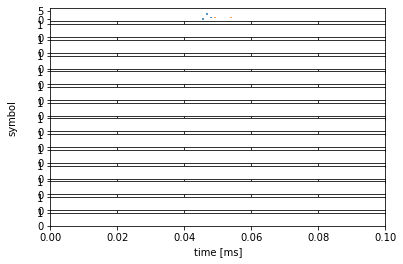

In [26]:
%matplotlib inline

plot_eventplot()

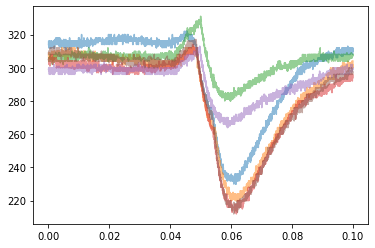

In [27]:
%matplotlib inline

external_membrane_recorded.record(None)

for i in range(alphabet_size):
    for j in range(num_neurons_per_symbol):
        if i != 0:
            continue
        external_membrane_recorded = pynn.PopulationView(excitatory[i][1], [j])
        external_membrane_recorded.record(["v", "spikes"])
        pynn.run(0.1)
        plot_membrane(external_membrane_recorded)
        external_membrane_recorded.record(None)

WARN  15:37:16,652  lib-rcf.OnDemandUpload.loop_upload Error while uploading: Unable to establish network connection. Operation now in progress


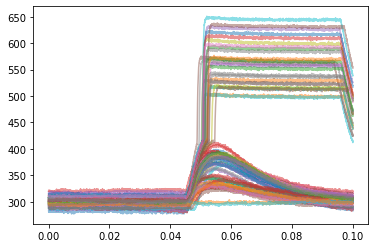

In [28]:
%matplotlib inline

external_membrane_recorded.record(None)

for i in range(alphabet_size):
    for j in range(num_neurons_per_symbol):
        if i == 0:
            continue
        external_membrane_recorded = pynn.PopulationView(excitatory[i][1], [j])
        external_membrane_recorded.record(["v", "spikes"])
        pynn.run(0.1)
        plot_membrane(external_membrane_recorded)
        external_membrane_recorded.record(None)